## Análise do algoritmo de reconstrução para a utilização de filtros

#### Plots gerados para dissertação

In [2]:
from root_pandas import read_root
import pandas as pd
import numpy as np
import sys
from utils.root_reader import RootReader
from glob import glob
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from matplotlib.ticker import (LinearLocator, MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from scipy import stats
from scipy.special import kl_div
import dataframe_image as dfi
import matplotlib
import dataframe_image as dfi
from KDEpy import FFTKDE
from scipy.stats import ks_2samp
from scipy.stats import kstest, normaltest
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def KL_div(p_probs, q_probs):    
    KL_div = p_probs * np.log(p_probs / q_probs)
    return np.sum(KL_div)
def JS_Div(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    # normalize
    p /= p.sum()
    q /= q.sum()
    m = (p + q) / 2
    return (KL_div(p, m) + KL_div(q, m)) / 2

def compare_dist(data1, data2):
    x_min = min([data1.min(), data2.min()])
    x_max = max([data1.max(), data2.max()])
    x = np.linspace(x_min-1, x_max+1, 10000)
    kde1 = FFTKDE(kernel='gaussian', bw='ISJ').fit(data1)
    kde2 = FFTKDE(kernel='gaussian', bw='ISJ').fit(data2)
    y1 = kde1.evaluate(x)
    y2 = kde2.evaluate(x)
    div = JS_Div(y1, y2)
    result = ks_2samp(data1.ravel(), data2.ravel())
    return [div, result] , [x, y1, y2]

## Leitura dos experimentos utilizando o algoritmo de reconstrução

In [4]:
folder = '../outputs/'
found_files = glob(f'{folder}*.root')
found_files = [i for i in found_files if not 'lime' in i]
df_list = []
erros_list = []
columns=['run', 'event', 'nCl', 
         'cl_integral', 'cl_length', 
         'cl_width', 'cl_nhits', 
         'cl_iteration','cl_xmean', 'cl_size',
         'cl_ymean', 'im_npixels_filter', 
         'im_npixels_rebin', 'pipe_filter_time', 
         'pipe_clustering_time', 'pipe_total_time',
         'sim_precision_filter', 'sim_recall_filter', 
         'sim_precision_rebin','sim_recall_rebin', 
         'sim_energy_truth', 'sim_energy_ideal_filter',
         'sim_energy_filter_intersect_truth',
         'pipe_pos_processing', 'pipe_zero_supressing',
         'im_npixels_noisered', 'sim_filter_threshold']  
for file_path in found_files:
    try:
        reader = RootReader(file_path, columns=columns)
        df = reader.transform()
        df_list.append(df)    
    except:
        erros_list.append(file_path)


all_data = pd.concat(df_list, axis=0)
run_map = pd.DataFrame({
    "run": [8000, 8001, 8002, 8003, 8004, 8005, 8006, 8007, 8008, 8009, 8010, 8011, 8012],
    "energy": [60, 30, 6, 30, 10, 1, 60, 6, 3, 3, 1, 100, 10],
    "particle": ['He', 'He', 'ER', 'ER', 'ER', 'He', 'ER', 'He', 'He', 'ER', 'ER', 'He', 'He']
})

all_data_include_info = pd.merge(all_data, run_map, on='run')
all_data_include_info['n_pts'] = all_data_include_info['n_pts'].astype(int)

## Leitura dos experimentos com a U-Net

In [24]:
contour_data_path = '../extras/contour/'
contour_file_lst = glob(f'{contour_data_path}*.csv')
contour_df_list = []
for f in contour_file_lst:
    df = pd.read_csv(f, index_col=False)
    contour_df_list.append(df)
contour_df = pd.concat(contour_df_list, axis=0)
contour_df.columns = ['cl_integral', 'pipe_total_time', 'event', 'run']
ideal_energy_df = all_data_include_info[['run', 'event', 'sim_energy_ideal_filter', 'particle', 'energy']].drop_duplicates()

unet_approach_df = pd.merge(ideal_energy_df, contour_df, on=['run', 'event'], how='left')
unet_approach_df['filter_name'] = 'unet-seg'

n_clu_df = unet_approach_df.groupby(['event', 'run']).size().reset_index()
n_clu_df.columns = ['event', 'run', 'nCl']
unet_approach_df = pd.merge(unet_approach_df, n_clu_df, on=['event', 'run'], how='left')

In [37]:
all_data_include_info = pd.concat([all_data_include_info, unet_approach_df], axis=0).reset_index(drop=True)

### Removendo runs que inviabilizam a análise proposta 

In [38]:
all_data_include_info_no_snake = (
    all_data_include_info
    .query('run != 8006 and run != 8003 and run != 8011')
)

## Distribuição de energia dos 

##### Eletron recoil

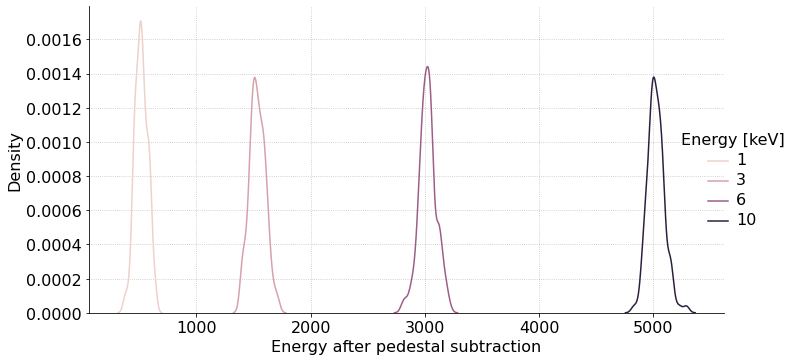

In [57]:
energy_df = (
    all_data_include_info_no_snake[
        ['event', 'energy', 
        'particle', 'sim_energy_truth',
        'sim_energy_ideal_filter']].drop_duplicates()
)
with sns.axes_style(style=None):
    ax = sns.displot(
        data=energy_df[energy_df['particle'] == 'ER'], 
        x="sim_energy_ideal_filter", 
        hue="energy", 
        height=5, 
        aspect=2, 
        kind="kde"
    )
ax.legend.get_title().set_text("Energy [keV]")
ax.legend.get_title().set_fontsize(16)
for text in ax.legend.texts:
    text.set_fontsize(16)
ax.axes[0,0].set_xlabel(r"Energy after pedestal subtraction", fontsize=16)
ax.axes[0,0].set_ylabel(r"Density", fontsize=16)            
ax.axes[0,0].grid(color='gray', linestyle=':', alpha = 0.5)
ax.axes[0,0].tick_params(axis='x', labelsize=16)
ax.axes[0,0].tick_params(axis='y', labelsize=16)
#plt.xlim([0, 6000])

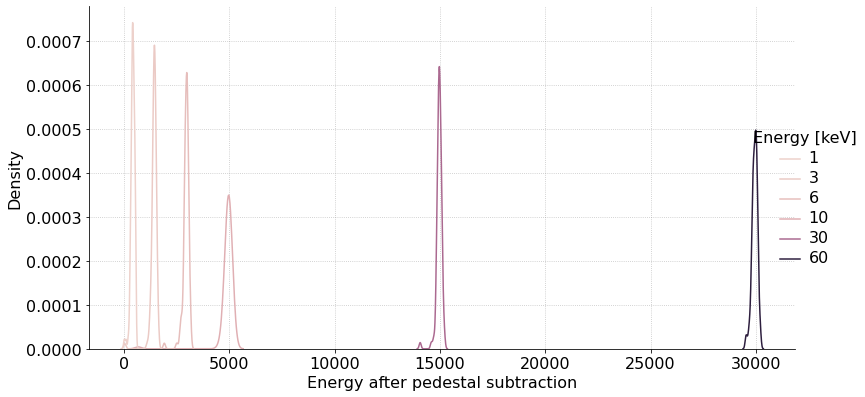

In [66]:
energy_df = (
    all_data_include_info_no_snake[
        ['event', 'energy', 
        'particle', 'sim_energy_truth',
        'sim_energy_ideal_filter']].drop_duplicates()
)
with sns.axes_style(style=None):
    ax = sns.displot(
        data=energy_df[energy_df['particle'] == 'He'], 
        x="sim_energy_ideal_filter", 
        hue="energy", 
        height=5.5, 
        aspect=2., 
        kind="kde"
    )
ax.legend.get_title().set_text("Energy [keV]")
ax.legend.get_title().set_fontsize(16)
for text in ax.legend.texts:
    text.set_fontsize(16)
ax.axes[0,0].set_xlabel(r"Energy after pedestal subtraction", fontsize=16)
ax.axes[0,0].set_ylabel(r"Density", fontsize=16)            
ax.axes[0,0].grid(color='gray', linestyle=':', alpha = 0.5)
ax.axes[0,0].tick_params(axis='x', labelsize=16)
ax.axes[0,0].tick_params(axis='y', labelsize=16)

## Verificando a linearidade da energia de entrada em relação a saída

In [84]:
ex = []
target = 'sim_energy_ideal_filter'
filters = all_data_include_info_no_snake.filter_name.unique()
n_pts = sorted(all_data_include_info_no_snake['n_pts'].unique())
energy = sorted(all_data_include_info_no_snake['energy'].unique())
particle = all_data_include_info_no_snake['particle'].unique()
test_pass = []
for e in energy:
    for n in n_pts:
        for p in particle:
            for f in filters:
                try:
                    if f == 'unet-seg':
                        rule = (
                        (all_data_include_info_no_snake['filter_name'] == f) & 
                        (all_data_include_info_no_snake['energy'] == e) & 
                        (all_data_include_info_no_snake['particle'] == p)
                    )
                    else:
                        rule = (
                            (all_data_include_info_no_snake['filter_name'] == f) & 
                            (all_data_include_info_no_snake['energy'] == e) & 
                            (all_data_include_info_no_snake['n_pts'] == n) & 
                            (all_data_include_info_no_snake['particle'] == p)
                        )
                    output_dataframe = (
                        all_data_include_info_no_snake[rule][
                            ['run', 'event', 
                            'cl_integral', 
                            'cl_iteration', 
                            target, 'particle']
                        ]
                    )
                    if (p == 'ER') & (e == 10):
                        output_dataframe = output_dataframe[output_dataframe.event != 7]
                    if (p == 'He') & (e == 6):
                        output_dataframe = output_dataframe[~(output_dataframe.event.isin([18, 30,60]))]

                    if (p == 'He') & (e == 30) & (f == 'cygno'):
                        output_dataframe = output_dataframe[~(output_dataframe.event.isin([71,46, 59]))]

                    output_dataframe = output_dataframe.sort_values('cl_integral')
                    output_dataframe.drop_duplicates(subset=['run', 'event'], keep='last', inplace=True)
    #g = sns.lmplot(x="cl_integral", y="sim_energy_truth", data=output_dataframe, hue="particle")

                    slope, intercept, r_value, p_value, std_err = stats.linregress(
                        output_dataframe['cl_integral'],
                        output_dataframe[target]
                    )
                    error = output_dataframe[target] - (slope*output_dataframe['cl_integral'] + intercept)
                    pi = stats.shapiro(error)[-1]
                    mse = (output_dataframe[target]-output_dataframe['cl_integral']).pow(2).mean()
                    if pi > 0.05:
                        test_pass.append([e, n, p, f, output_dataframe.shape[0], slope, intercept, r_value, pi, mse])
                    else:
                        ex.append([e, n, p, f])
                except ValueError:
                    continue

##### Aplicando algumas transformações no resultado

In [85]:
linearity_result_df = pd.DataFrame(test_pass, columns=['energy', 'n_pts', 'particle', 'filter_name', 'n_events', 'slope', 'intercept', 'r_value', 'pi', 'mse'])
all_events_df = all_data_include_info[['run', 'event', 'sim_energy_truth' , 'energy', 'particle']].drop_duplicates()
all_events_df = all_events_df.groupby(['energy', 'particle']).agg({'sim_energy_truth':'count'}).reset_index()
all_events_df.rename(columns={'sim_energy_truth':'total_events'}, inplace=True)
linearity_result_df = linearity_result_df.merge(all_events_df, on=['energy', 'particle'])
linearity_result_df['found_events'] = linearity_result_df['n_events']/linearity_result_df['total_events']
linearity_result_df['score'] = (2*linearity_result_df['found_events']*linearity_result_df['r_value'])/(linearity_result_df['found_events'] + linearity_result_df['r_value'])

##### Selecionando os melhores para cada filtro

In [86]:
list_result = []
for e in energy:
    for p in particle:
        aux = linearity_result_df[(linearity_result_df['energy'] == e) & (linearity_result_df['particle'] == p)].sort_values(by=['score'], ascending=False).drop_duplicates(subset="filter_name")
        list_result.append(aux)
lm_result = pd.concat(list_result)

##### Gerando mais algumas features

In [87]:
lm_result["intercept_standardized"] = lm_result["intercept"]/(500*lm_result["energy"])
lm_result['found_events_percent'] = lm_result['found_events']*100
lm_result["mse_standardized"] = lm_result["mse"]/(500*lm_result["energy"])

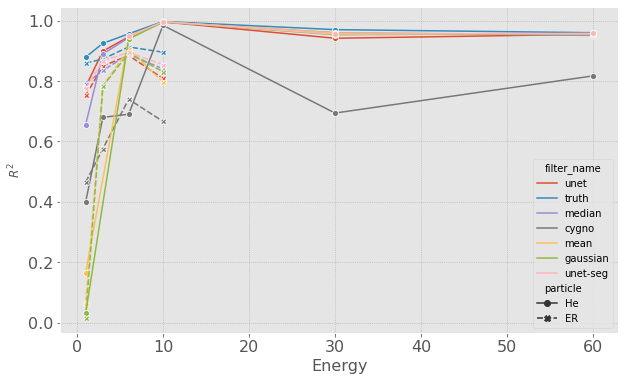

In [89]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
font = 16
ax = sns.lineplot(data=lm_result, x="energy", y="r_value", hue="filter_name", style="particle",  markers=True)
ax.set_ylabel("$R^{2}$")
ax.set_xlabel(r"Energy",fontsize=font)
#ax.set_ylabel(r"Found clusters (%)", fontsize=font)            
ax.grid(color='gray', linestyle=':', alpha = 0.5)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
#plt.savefig("../../plots/clusters_result_sim.png", transparent=False)

In [79]:
linearity_result_df.filter_name.unique()

array(['mean', 'unet', 'gaussian', 'median', 'truth', 'cygno'],
      dtype=object)

In [83]:
pd.DataFrame(ex, columns=['energy', 'n_pts', 'particle', 'filter_name']).filter_name.unique()

array(['gaussian', 'mean', 'unet', 'median', 'cygno'], dtype=object)